<font size="20">Predicting Stock Market Trends Using Predictive Analytics, SARIMA Analysis</font>

Author: Yagnesh Rajani

<font size="20" color = "Blue">Libraries, Packages and Data Setup</font>

Install and Import Libraries and Packages

In [71]:
#%pip install matplotlib
#%pip install pandas
#%pip install pmdarima
#%pip install scikit-learn

import sklearn.metrics as metrics
from matplotlib import pyplot as plt
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima

Import Datasets

In [72]:
raw_dataset = pd.DataFrame(pd.read_csv("dataset.csv", sep = ",", header = 0, parse_dates=['Date']))

Format Date to fit Modeling Requirements

In [73]:
attribute_list = ['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits']
dataset = raw_dataset[attribute_list]
date = raw_dataset['Date']
date = date.astype('string')
date = date.str[:-15]
dataset.insert(0, "Date", date)
dataset.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,1962-01-02,0.058398,0.060358,0.058398,0.058398,841958,0.0,0.0
1,1962-01-03,0.058398,0.059378,0.058398,0.059182,801865,0.0,0.0
2,1962-01-04,0.059182,0.059378,0.058791,0.059182,962238,0.0,0.0
3,1962-01-05,0.059182,0.059574,0.058987,0.059378,962238,0.0,0.0
4,1962-01-08,0.059378,0.060162,0.058007,0.059182,1282984,0.0,0.0


Model Evaluation Setup

In [74]:
evals = []
def evaluations(test, pred):
    mae = metrics.mean_absolute_error(test, pred)
    mape = metrics.mean_absolute_percentage_error(test, pred)
    mse = metrics.mean_squared_error(test, pred)
    rmse = mse**0.5
    #evals = {'MAE': mae, "MAPE": mape, "MSE": mse, "RMSE": rmse}
    evals = [mae, mape, mse, rmse]
    return(evals)

<font size="6" color = "Orange">Split the Data Into Training and Testing Datasets</font>

Find the Index Where the Data Will be Split

In [75]:
# Get the index where the training and test datasets will be split from
# Note that due to the abundance of data, we are using an 80% training and 20% testing split
splitval = 0.80
div_index = round(dataset.shape[0] * splitval)
print("The index where the data will be split is: ", div_index)

The index where the data will be split is:  12358


Split the Dataset

In [76]:
train_data = dataset[:div_index]
test_data = dataset[div_index:]

Find the Index of the First Day in 2020

In [77]:
covid_index = dataset[dataset['Date'] == "2020-01-02"].index.values
print(covid_index)

[14600]


Split the Dataset for the Covid Model

In [78]:
covid_train_data = dataset[:covid_index[0]]
covid_test_data = dataset[covid_index[0]:]

<font size="6" color = "Orange">Model Training and Testing</font>

Compute Seasonal Index

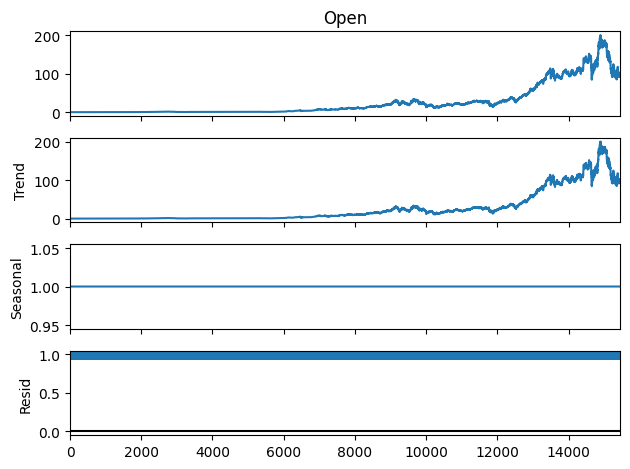

In [79]:
seasonal_index = seasonal_decompose(dataset['Open'], model='multiplicative', period = 1)
seasonal_index.plot()
plt.show()

Fit the Data to The Model

In [80]:
# Create list to store the p, d, q values
order_list = []

# Find the arima p, d, q values
for values in attribute_list:
    model = auto_arima(dataset[values], 
                       error_action='ignore', 
                       suppress_warnings=True, 
                       stepwise=False, 
                       seasonal=True)
    order_list.append(model.order)

# Fit the data to the model
for values in attribute_list:
    p, d, q = order_list[attribute_list.index(values)]
    model = SARIMAX(train_data[values], order=(p,d,q), seasonal_order=())
    fitted_model = model.fit()

ValueError: `seasonal_order` argument must be an iterable with four elements.

Print the Model Fits

In [ ]:
print(order_list)

[(1, 0, 0), (1, 0, 0), (1, 0, 0), (1, 0, 0), (1, 0, 0), (1, 0, 0), (1, 0, 0)]


Train the Model

In [ ]:
prediction_eval = pd.DataFrame(columns = ["MAE", "MAPE", "MSE", "RMSE"])

for values in attribute_list:
    p, d, q = order_list[attribute_list.index(values)]

    # Fit ARIMA model
    train_model = auto_arima(train_data[values], seasonal = True)
    # Create a prediction based on the number of items in the test data
    prediction_model = train_model.predict(n_periods = len(test_data[values]))

    # Calculate metrics using the evaluations function
    predictions = pd.Series(prediction_model)
    prediction_eval.loc[values] = evaluations(test_data[values], predictions)

    # Display the test data (actual) overlayed with the prediction data
    fig, ax = plt.subplots(figsize = (20,5))
    prediction_model.plot(ax = ax, color = 'r')
    test_data[values].plot(ax = ax)
    plt.xlabel("Time")
    plt.ylabel(values)
    plt.show()

<font size="6" color = "Orange">COVID Model Training and Testing</font>

Fit the Data to The Model

In [ ]:
# Create list to store the p, d, q values
covid_order_list = []

# Find the arima p, d, q values
for values in attribute_list:
    covid_model = auto_arima(dataset[values], 
                       error_action='ignore', 
                       suppress_warnings=True, 
                       stepwise=False, 
                       seasonal=True)
    covid_order_list.append(covid_model.order)

# Fit the data to the model
for values in attribute_list:
    p, d, q = covid_order_list[attribute_list.index(values)]
    covid_model = SARIMAX(covid_train_data[values], order=(p,d,q), seasonal_order = ())
    covid_fitted_model = covid_model.fit()

Print the Model Fits

In [ ]:
print(covid_order_list)

Train the Model on the Covid Training Data and Apply it to the Covid Test Data

In [ ]:
covid_prediction_eval = pd.DataFrame(columns = ["MAE", "MAPE", "MSE", "RMSE"])

for values in attribute_list:
    p, d, q = order_list[attribute_list.index(values)]

    # Fit ARIMA model
    covid_train_model = auto_arima(covid_train_data[values], seasonal = True)
    # Create a prediction based on the number of items in the test data
    covid_prediction_model = covid_train_model.predict(n_periods = len(covid_test_data[values]))

    # Calculate metrics using the evaluations function
    covid_predictions = pd.Series(covid_prediction_model)
    covid_prediction_eval.loc[values] = evaluations(covid_test_data[values], covid_predictions)

    # Display the test data (actual) overlayed with the prediction data
    fig, ax = plt.subplots(figsize = (20,5))
    covid_prediction_model.plot(ax = ax, color = 'r')
    test_data[values].plot(ax = ax)
    plt.xlabel("Time")
    plt.ylabel(values)
    plt.show()

<font size="6" color = "Orange">Model Evaluation</font>

Regular Model Metrics

In [ ]:
prediction_eval

Covid Model Metrics

In [ ]:
covid_prediction_eval